In [9]:
#bibliotecas
import pandas as pd
import numpy as np
import time
import os

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [10]:
# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


# Importando o Dataset 

Fonte de Dados: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

### Glossário:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

### Upload dos dados


In [11]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip  

--2022-12-30 16:14:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.04s   

2022-12-30 16:14:52 (6.81 MB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Readme.txt              
replace day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: day.csv                 
  inflating: hour.csv                


In [12]:
!ls

Bike-Sharing-Dataset.zip    day.csv   Readme.txt
Bike-Sharing-Dataset.zip.1  hour.csv  sample_data


In [17]:
df = pd.read_csv('hour.csv')
pd.set_option('display.max_columns',17)
df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [14]:
df.shape

(17379, 17)

### Dataset de Treino e Teste

In [16]:

# Train/Test split
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test  = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
!ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip    bike_test.csv   day.csv   Readme.txt
Bike-Sharing-Dataset.zip.1  bike_train.csv  hour.csv  sample_data


# Classe Datasets Pytorch 

In [20]:
class MyDataset(Dataset):
  def __init__(self,csv_path,scaler_feat=None,scaler_label=None):
      self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self,idx):
    
    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]

    # converter para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))

    return sample,label

  def __len__(self):
    return len(self.dados)


# Setup Teste e Treino

In [23]:
#criando o dataset para usar no Pytorch
train_set = MyDataset('bike_train.csv')
test_set = MyDataset('bike_test.csv')

#verificando se a classe implementou corretamente
dado,rotulo = train_set[0]
print(dado)
print(rotulo)

tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])
tensor([373.])


In [24]:
#criando os batchs de teste e treino
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers = args['num_workers'],
                          shuffle=True
                          )

test_loader = DataLoader(test_set,
                          args['batch_size'],
                          num_workers = args['num_workers'],
                          shuffle=True
                          )

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [56]:
#visualizando como o DataLoader entrega os dados
for batch in test_loader:
  dado,rotulo = batch

  print('Dado: {}'.format(dado.size()))
  print('Rotulo: {}'.format(rotulo.size()))

  break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Dado: torch.Size([20, 12])
Rotulo: torch.Size([20, 1])


# Criação da Rede Neural Multi Layer Perceptron (MLP)

In [36]:
class MLP(nn.Module):
  
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):
    
    hidden = self.features(X)
    output = self.classifier(hidden)
    
    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


### Selecionando a função de perda

In [61]:
criterion = nn.MSELoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Treinando e Testando

In [62]:
def train(train_loader, net, epoch):
  #train mode
  net.train()

  start = time.time()

  epoch_loss = []

  for batch in train_loader:

    dado,rotulo = batch

    # cast na gpu
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # forward
    ypred = net(dado)
    loss = criterion(ypred,rotulo)
    epoch_loss.append(loss.cpu().data)

    # backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()

  print('################# Train #################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(),end-start))

  return epoch_loss.mean()

In [63]:
def test(test_loader, net, epoch):
  #test mode
  net.eval()

  start = time.time()

  epoch_loss = []

  with torch.no_grad():
    for batch in test_loader:

      dado,rotulo = batch

      # cast na gpu
      dado   = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # forward
      ypred = net(dado)
      loss = criterion(ypred,rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()

  print('################# Test #################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(),end-start))

  return epoch_loss.mean()

In [64]:
train_losses = []
test_losses  = []
for epoch in range(args['epoch_num']): 
  # Train
  train_losses.append(train(train_loader, net, epoch))
  # train(train_loader, net, epoch)

  # Validate
  test_losses.append(test(test_loader, net, epoch))
  # test(test_loader, net, epoch)
  

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


################# Train #################
Epoch 0, Loss: 3291.9922 +/- 2202.3818, Time: 3.07
################# Test #################
Epoch 0, Loss: 3794.2896 +/- 2197.6306, Time: 0.56
################# Train #################
Epoch 1, Loss: 3256.1172 +/- 2038.4893, Time: 2.99
################# Test #################
Epoch 1, Loss: 3639.3987 +/- 2337.6890, Time: 0.56
################# Train #################
Epoch 2, Loss: 3307.6250 +/- 2182.6294, Time: 2.85
################# Test #################
Epoch 2, Loss: 3632.5935 +/- 2122.2227, Time: 0.56
################# Train #################
Epoch 3, Loss: 3278.1069 +/- 1937.1056, Time: 2.84
################# Test #################
Epoch 3, Loss: 3623.4807 +/- 1974.9961, Time: 0.55
################# Train #################
Epoch 4, Loss: 3404.8794 +/- 2070.9160, Time: 2.93
################# Test #################
Epoch 4, Loss: 3947.4131 +/- 2073.1272, Time: 0.56
################# Train #################
Epoch 5, Loss: 3414.1294 +/- 2122

### Comparando Treino e Teste

In [65]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest,ypred),axis=1)

df_results = pd.DataFrame(data,columns=['ypred','ytest'])
df_results.head(6)

,ypred,ytest
0,tensor(352.),tensor(324.4360)
1,tensor(156.),tensor(120.0086)
2,tensor(12.),tensor(13.8559)
3,tensor(2.),tensor(13.8559)
4,tensor(391.),tensor(314.0733)
5,tensor(391.),tensor(320.3743)


# Gráfico de convergência

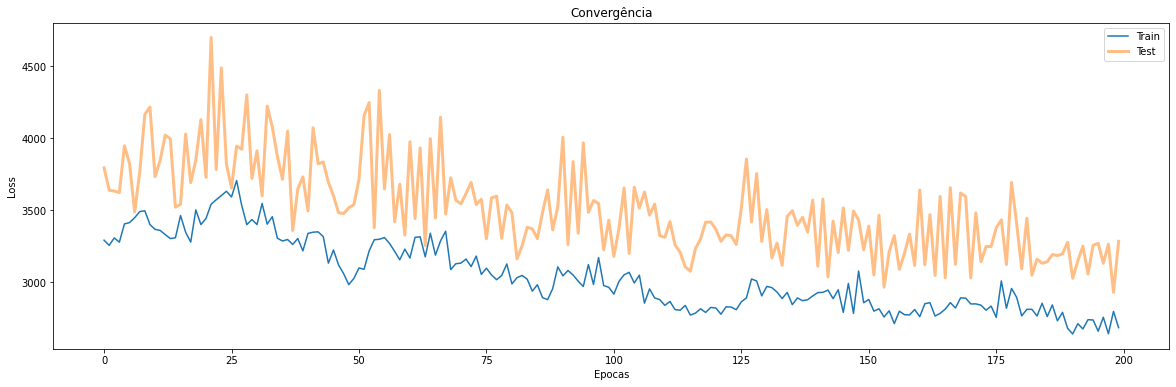

In [66]:
plt.figure(figsize=(20,6))
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test',linewidth=3,alpha=0.5)
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.title('Convergência')
plt.legend()
plt.show()

# Unindo Treino e Teste em uma só função

In [52]:
def forward(loader, net, epoch,mode):
  
  start = time.time()
  epoch_loss = []
  if mode=='train':
    net.train()

  else:
    net.eval()

  for batch in loader:
    dado,rotulo = batch

    # cast na gpu
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # forward
    ypred = net(dado)
    loss = criterion(ypred,rotulo)
    epoch_loss.append(loss.cpu().data)

    if mode=='train':
      # backward
      loss.backward()
      optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()

  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(),end-start))

  return epoch_loss.mean()

In [ ]:
train_losses = []
test_losses  = []
for epoch in range(args['epoch_num']): 
  # Train
  train_losses.append(forward(train_loader, net, epoch,"train"))
  # train(train_loader, net, epoch)

  # Validate
  test_losses.append(forward(test_loader, net, epoch,"test"))
  # test(test_loader, net, epoch)